### T-test 

In [1]:
# from __future__ import print_function, division
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os
import sys
import pandas as pd
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
from keras_bert import load_vocabulary
import matplotlib.pyplot as plt

from scipy.stats import t
from scipy import stats
    
from methods.preprocessing import Preprocess
from methods.baseline import Baseline
from methods.retrieval import Retrieval
from approaches.deepQL_topics import run as deepql_topics_run

from methods.evaluation import Evaluation, EvaluationPrecision, EvaluationRecall, EvaluationFscore

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html

In [59]:
DOMAIN = "openoffice"
PREPROCESSING = 'bert'
TOKEN = 'bert'
normalized = os.path.join('data/normalized', DOMAIN, '{}.csv'.format(DOMAIN))
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
for TEST in [['deepQL_topics', 'baseline']]:
    recall = {}
    for MODEL in TEST:
        RANK =  os.path.join('data/processed', DOMAIN, TOKEN, 'exported_rank_{}_1000.txt'.format(MODEL))
        evaluate = Evaluation(0)
        evaluate.evaluate(RANK)
        report = evaluate.get_recalls()
        recall[MODEL] = report
recall

{'baseline': {'0 - recall_at_1': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
 

In [92]:
position = '5'
recall_at = '25'
y_train = np.array(range(len(recall['deepQL_topics']['{} - recall_at_{}'.format(position, recall_at)])))
y_test = np.array(range(len(recall['baseline']['{} - recall_at_{}'.format(position, recall_at)])))
A_score = np.array(recall['deepQL_topics']['{} - recall_at_{}'.format(position, recall_at)])
B_score = np.array(recall['baseline']['{} - recall_at_{}'.format(position, recall_at)])


y = np.concatenate([y_train, y_test])

(array([6321.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0., 5436.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <a list of 15 Patch objects>)

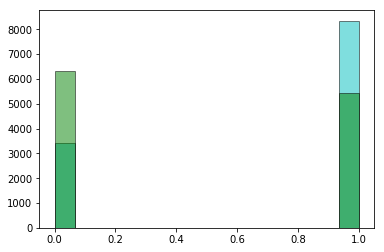

In [93]:
plt.hist(A_score, bins=15, color='c', edgecolor='k', alpha=0.5)
plt.hist(B_score, bins=15, color='g', edgecolor='k', alpha=0.5)

In [94]:
_, Pvalue = stats.ttest_rel(A_score, B_score)
# Compouter diferrence value between scores 
Dvalue = round(np.mean(A_score - B_score), 2)
print("Diference score", Dvalue)
print("P-value", Pvalue)
print("reject null hypothesis", Pvalue > 0.05)

Diference score 0.25
P-value 0.0
reject null hypothesis False


In [95]:
_, Pvalue = stats.wilcoxon(A_score, B_score)
# Compouter diferrence value between scores 
Dvalue = round(np.mean(A_score - B_score), 2)
print("Diference score", Dvalue)
print("P-value", Pvalue)
print("reject null hypothesis", Pvalue > 0.05)

Diference score 0.25
P-value 0.0
reject null hypothesis False


In [96]:
dup_method_A = [x for x in A_score if x == 1.0]
dup_method_B = [x for x in B_score if x == 1.0]

qtd_dup_method_A = len(dup_method_A)
qtd_dup_method_B = len(dup_method_B)
qtd_non_dup_method_A = len(A_score) - qtd_dup_method_A
qtd_non_dup_method_B = len(B_score) - qtd_dup_method_B

# A_score_table = [qtd_non_dup_method_A / len(A_score), qtd_dup_method_A / len(A_score)]
# B_score_table = [qtd_non_dup_method_B / len(B_score), qtd_dup_method_B / len(B_score)]

A_score_table = np.array([qtd_dup_method_A, qtd_non_dup_method_A], float)
B_score_table = np.array([qtd_dup_method_B, qtd_non_dup_method_B], float)

A_score_table, B_score_table

(array([8344., 3413.]), array([5436., 6321.]))

In [97]:
_, Pvalue = stats.fisher_exact([A_score_table, B_score_table], alternative='two-sided')
# Compouter diferrence value between scores 
Dvalue = round(np.mean(A_score - B_score), 2)
print("Diference score", Dvalue)
print("P-value", Pvalue)
print("reject null hypothesis", Pvalue > 0.05)

Diference score 0.25
P-value 0.0
reject null hypothesis False


In [98]:
_, Pvalue = stats.chisquare(A_score_table, B_score_table)
# Compouter diferrence value between scores 
Dvalue = round(np.mean(A_score - B_score), 2)
print("Diference score", Dvalue)
print("P-value", Pvalue)
print("reject null hypothesis", Pvalue > 0.05)

Diference score 0.25
P-value 0.0
reject null hypothesis False
